**17.4: Bounding portfolio risk with incomplete covariance information**

In [ ]:
import cvxpy as cp
import numpy as np

# Portfolio weights and known diag elements of variacne matrix
x = np.array([0.1, 0.2, -0.05, 0.1])
diag_elements = np.array([0.2, 0.1, 0.3, 0.1])

# Variables for off-diagonal elements
sigma_12 = cp.Variable()
sigma_13 = cp.Variable()
sigma_14 = cp.Variable()
sigma_23 = cp.Variable()
sigma_24 = cp.Variable()
sigma_34 = cp.Variable()

# Construct Sigma matrix
Sigma = cp.bmat([
    [diag_elements[0], sigma_12, sigma_13, sigma_14],
    [sigma_12, diag_elements[1], sigma_23, sigma_24],
    [sigma_13, sigma_23, diag_elements[2], sigma_34],
    [sigma_14, sigma_24, sigma_34, diag_elements[3]]
])

# Sign constraints
constraints = [
    sigma_12 >= 0,  # Sigma[1,2] >= 0
    sigma_13 >= 0,  # Sigma[1,3] >= 0
    sigma_23 <= 0,  # Sigma[2,3] <= 0
    sigma_24 <= 0,  # Sigma[2,4] <= 0
    sigma_34 >= 0   # Sigma[3,4] >= 0
]

# Solve optimization problem
prob = cp.Problem(
    cp.Maximize(cp.quad_form(x, Sigma)),
    constraints + [Sigma >> 0]
)
prob.solve()

# Extract results
Sigma_wc = np.array([
    [diag_elements[0], sigma_12.value, sigma_13.value, sigma_14.value],
    [sigma_12.value, diag_elements[1], sigma_23.value, sigma_24.value],
    [sigma_13.value, sigma_23.value, diag_elements[2], sigma_34.value],
    [sigma_14.value, sigma_24.value, sigma_34.value, diag_elements[3]]
])
diag_var = np.sum(x**2 * diag_elements)

ratio_wc = prob.value/ diag_var

print(f"Worst-case variance: {prob.value:.6f}")
print(f"Diagonal variance: {diag_var:.6f}")
print(f'Ratio:  {ratio_wc: .6f}')
print("\nOptimal Sigma:\n", Sigma_wc)

Worst-case variance: 0.015166
Diagonal variance: 0.007750
Ratio:   1.956929

Optimal Sigma:
 [[ 2.00000000e-01  8.82242409e-02 -1.10125774e-06  9.32336197e-02]
 [ 8.82242409e-02  1.00000000e-01 -1.20196773e-01 -1.03476482e-07]
 [-1.10125774e-06 -1.20196773e-01  3.00000000e-01  3.81381837e-02]
 [ 9.32336197e-02 -1.03476482e-07  3.81381837e-02  1.00000000e-01]]


**13.16: option price bounds**

In [ ]:
import cvxpy as cp
import numpy as np

# Market parameters
r, S0 = 1.05, 1.0
F, C = 0.9, 1.15

# Generate scenarios and traded options data
S = np.linspace(0.5, 2.0, 200)
options = [
    {'type': 'call', 'strike': 1.1, 'price': 0.06},
    {'type': 'call', 'strike': 1.2, 'price': 0.03},
    {'type': 'put',  'strike': 0.8, 'price': 0.02},
    {'type': 'put',  'strike': 0.7, 'price': 0.01}
]

# Calculate option payoffs
def get_option_payoffs(S, options):
    payoffs = []
    for opt in options:
        payoff = np.maximum(S - opt['strike'], 0) if opt['type'] == 'call' \
                 else np.maximum(opt['strike'] - S, 0)
        payoffs.append(payoff)
    return np.array(payoffs)

# Calculate collar payoff
def get_collar_payoff(S, S0, F, C):
    payoff = np.minimum(np.maximum(S - S0, F - S0), C - S0)
    return payoff

# All payoffs
payoff_options = get_option_payoffs(S, options)
payoff_collar = get_collar_payoff(S, S0, F, C)

# Optimization problem
p = cp.Variable(len(S), nonneg=True)

# Build constraints list
constraints = [cp.sum(p) == 1]                    # Probability sum
constraints.append((1/r) * (p @ S) == S0)         # expected future price of underlying asset must equal its current price

# Add option pricing constraints
for payoff, opt in zip(payoff_options, options):
    constraints.append((1/r) * (p @ payoff) == opt['price']) # expected future price of traded options must equal its current price

# Solve for min and max collar prices
collar_price = (1/r) * (p @ payoff_collar)
results = {}
for objective in [cp.Minimize, cp.Maximize]:
    prob = cp.Problem(objective(collar_price), constraints)
    prob.solve()
    results[objective.__name__] = prob.value

print(f"Minimum collar price: {results['Minimize']:.6f}")
print(f"Maximum collar price: {results['Maximize']:.6f}")

Minimum collar price: 0.032619
Maximum collar price: 0.064950


**Utility versus latency trade-off in a network**

Maximum Utility U_max: -354.79635025664993
Minimum Latency L_min: 61.73627333912472


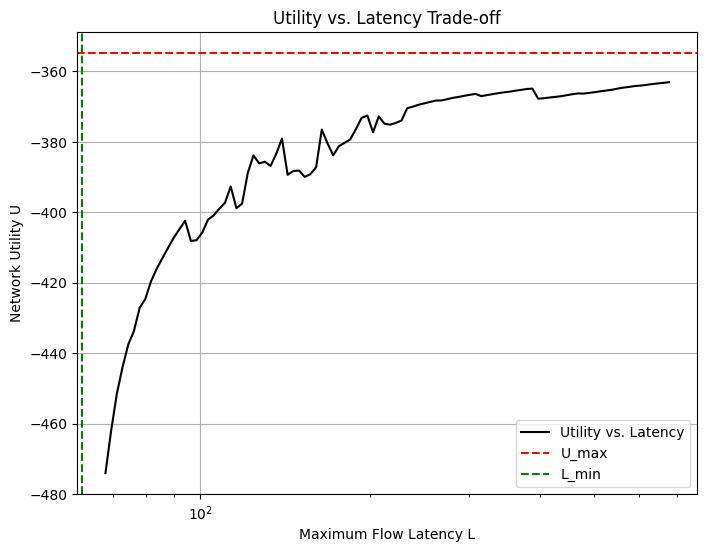

In [ ]:
import numpy as np
import cvxpy as cp
import scipy.io
import matplotlib.pyplot as plt

# Load network data from net_util_data.mat
data = scipy.io.loadmat('net_util_data.mat')
R = data['R']       # Routing matrix (m x n)
c = data['c'].flatten()  # Link capacities (m,)

# Get the number of links (m) and flows (n)
m, n = R.shape

# 1. Compute U_max (Maximum Utility)
# Maximize U(f) = sum(log(f_j)) subject to Rf <= c, f >= 0

# Define the optimization variable for flow rates
f = cp.Variable(n, pos=True)  # Flow rates (f_j > 0)

# Define the constraints
constraints = [R @ f <= c]

# Define the objective function
objective = cp.Maximize(cp.geo_mean(f))

# Solve the optimization problem
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.SCS)

# Get the maximum utility
U_max = n * np.log(prob.value)  # Since U_max = n * log(geo_mean(f))
f_Umax = f.value  # Optimal flow rates corresponding to U_max

print("Maximum Utility U_max:", U_max)

# 2. Compute L_min (Minimum Latency)
# Can be done analytically: take f = 0, so t = 0, d_i = 1 / c_i
d_zero = 1 / c  # Since t = 0
l_zero = R.T @ d_zero  # Flow latencies
L_min = np.max(l_zero)  # Maximum flow latency

print("Minimum Latency L_min:", L_min)

# 3. Generate the trade-off curve between utility and latency

N = 100
ds = 1.10 * L_min * np.logspace(0, 1, N)  # From 1.1*L_min to 11*L_min

U_values = []
L_values = ds  # The latency limits used

for d in ds:
    # Define the optimization variable for flow rates
    f = cp.Variable(n, pos=True)  # f_j > 0

    # Define the constraints
    # Latency constraint: R.T @ inv_pos(c - R @ f) <= d * np.ones(n)
    latency_constraint = R.T @ cp.inv_pos(c - R @ f) <= d * np.ones(n)
    # Note: R @ f <= c is not needed; enforced by domain of inv_pos
    # f >= 0 is enforced by domain of geo_mean

    constraints = [latency_constraint]

    # Define the objective function
    objective = cp.Maximize(cp.geo_mean(f))

    # Solve the optimization problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    # Store the utility value
    if prob.status == cp.OPTIMAL or prob.status == cp.OPTIMAL_INACCURATE:
        Uopt = n * np.log(prob.value)
        U_values.append(Uopt)
    else:
        # If the problem is infeasible, append NaN
        U_values.append(np.nan)

# Convert lists to numpy arrays for plotting
U_values = np.array(U_values)
L_values = np.array(L_values)

# 4. Plot the utility versus latency trade-off

plt.figure(figsize=(8, 6))
plt.semilogx(L_values, U_values, 'k-', label='Utility vs. Latency')
plt.axhline(y=U_max, color='r', linestyle='--', label='U_max')
plt.axvline(x=L_min, color='g', linestyle='--', label='L_min')
plt.xlabel('Maximum Flow Latency L')
plt.ylabel('Network Utility U')
plt.title('Utility vs. Latency Trade-off')
plt.legend()
plt.grid(True)
plt.show()


**15.2 → SINR maximization**

In [ ]:
import numpy as np
import cvxpy as cp

n = 5
group1 = [0, 1]
group2 = [2, 3, 4]
p_max = 3
group1_power_limit = 4
group2_power_limit = 6
sigma = 0.5
received_power_limit = 5

G = np.array([
    [1.0, 0.1, 0.2, 0.1, 0.0],
    [0.1, 1.0, 0.1, 0.1, 0.0],
    [0.2, 0.1, 2.0, 0.2, 0.2],
    [0.1, 0.1, 0.2, 1.0, 0.1],
    [0.0, 0.0, 0.2, 0.1, 1.0]
])

# Initialize gamma bounds
gamma_min = 0
gamma_max = 500

# Bisection parameters
tolerance = 0.05
max_iterations = 50

# Bisection algorithm
iteration = 0
p_optimal = None  # To store the optimal power allocation
gamma_optimal = None  # To store the optimal gamma value

while gamma_max - gamma_min > tolerance and iteration < max_iterations:
    iteration += 1
    gamma = (gamma_min + gamma_max) / 2

    # Define variables
    p = cp.Variable(n)
    constraints = []

    # Individual power constraints
    constraints += [p >= 0, p <= p_max]

    # Group power constraints
    constraints += [cp.sum(p[group1]) <= group1_power_limit]
    constraints += [cp.sum(p[group2]) <= group2_power_limit]

    # Total received power constraints for each receiver
    for i in range(n):
        constraints += [G[i, :] @ p <= received_power_limit]

    # SINR constraints for each receiver
    for i in range(n):
        interference = G[i, :] @ p - G[i, i] * p[i]
        sinr_constraint = G[i, i] * p[i] - gamma * interference >= gamma * sigma
        constraints += [sinr_constraint]

    # Solve the feasibility problem
    prob = cp.Problem(cp.Minimize(0), constraints)
    result = prob.solve(solver=cp.SCS, verbose=False)

    if prob.status == cp.OPTIMAL or prob.status == cp.OPTIMAL_INACCURATE:
        # Feasible solution found
        gamma_min = gamma  # Update lower bound
        p_optimal = p.value
        gamma_optimal = gamma
    else:
        # Infeasible, update upper bound
        gamma_max = gamma

# Round final gamma to four decimal places for reporting
gamma_optimal = round(gamma_min, 4)

# Print the results
print(f"Maximum SINR value: {gamma_optimal}")
print("Optimal transmitter powers:")
for j in range(n):
    print(f"p_{j+1} = {p_optimal[j]:.4f}")

# Compute and display the SINR values for each receiver
print("\nSINR values for each receiver:")
for i in range(n):
    interference = G[i, :] @ p_optimal - G[i, i] * p_optimal[i]
    sinr_i = (G[i, i] * p_optimal[i]) / (sigma + interference)
    print(f"SINR_{i+1} = {sinr_i:.4f}")


Maximum SINR value: 1.6785
Optimal transmitter powers:
p_1 = 2.1085
p_2 = 1.8739
p_3 = 1.6380
p_4 = 2.3736
p_5 = 1.8057

SINR values for each receiver:
SINR_1 = 1.6836
SINR_2 = 1.6852
SINR_3 = 1.6843
SINR_4 = 1.6877
SINR_5 = 1.6955


**20.8**

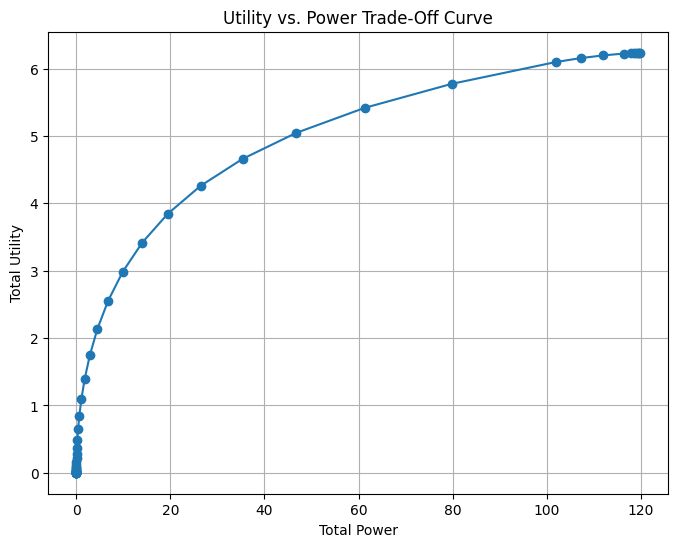

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


m = 20
n = 10

# Generate routing matrix R
np.random.seed(3)
R = np.round(np.random.rand(m, n))

# Parameters
p_max = 10  # Maximum transmit power for each link
alpha = np.ones(m)
beta = np.ones(m)
c_max = np.log(1 + beta * p_max)  # c_i^max = ln(1 + p_i^max)
lambda_values = np.logspace(-3, 3, num=50)  # Varying lambda from 1e-3 to 1e3

# Storage for results
utility_values = []
power_values = []

for lam in lambda_values:
    # Variables
    f = cp.Variable(n, nonneg=True)
    c = cp.Variable(m)

    # Compute p_i as function of c_i
    p = cp.exp(c) - 1

    # Objective function
    objective = cp.Maximize(cp.sum(cp.sqrt(f)) - lam * cp.sum(p))

    # Constraints
    constraints = [
        R @ f <= c,
        c >= 0,
        c <= c_max,
        p <= p_max,
    ]

    # Problem definition
    prob = cp.Problem(objective, constraints)

    # Solve the problem
    prob.solve()

    # Check if the problem is solved successfully
    prob.status == cp.OPTIMAL
    total_utility = sum(np.sqrt(f.value))
    total_power = sum(p.value)
    utility_values.append(total_utility)
    power_values.append(total_power)



# Plot the trade-off curve
plt.figure(figsize=(8, 6))
plt.plot(power_values, utility_values, marker='o')
plt.xlabel('Total Power')
plt.ylabel('Total Utility')
plt.title('Utility vs. Power Trade-Off Curve')
plt.grid(True)
plt.show()


**15.14: Wireless Communication Power Optimization**

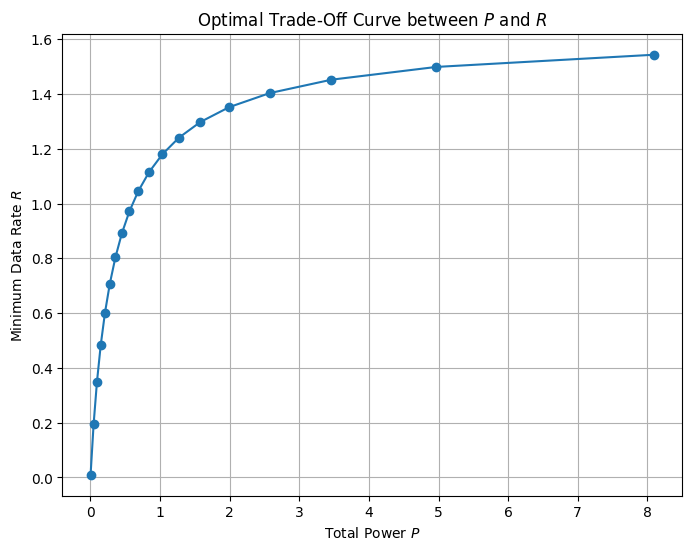

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Problem Data
n = 10
alpha = 1
sigma2 = np.array([0.82, 0.91, 0.16, 0.18, 0.28, 0.2, 0.04, 0.07, 0.36, 0.97])
pmin = 0
pmax = 1.5
G = np.array([
    [13.0, 0.47, 0.84, 0.95, 0.2, 0.05, 0.8, 0.09, 0.48, 0.71],
    [0.54, 29.0, 0.91, 0.8, 0.87, 0.48, 0.51, 0.95, 0.06, 0.44],
    [0.26, 0.35, 27.0, 0.12, 0.65, 0.67, 0.39, 0.78, 0.47, 0.28],
    [0.91, 0.77, 0.72, 11.0, 0.59, 0.84, 0.48, 0.18, 0.38, 0.34],
    [0.17, 0.04, 0.12, 0.08, 21.0, 0.17, 0.07, 0.08, 0.98, 0.24],
    [0.66, 0.27, 0.77, 0.78, 0.74, 29.0, 0.48, 0.68, 0.22, 0.07],
    [0.58, 0.07, 0.8, 0.1, 0.55, 0.78, 18.0, 0.93, 0.86, 0.11],
    [0.87, 0.16, 0.04, 0.84, 0.48, 0.51, 0.45, 11.0, 0.07, 0.89],
    [0.97, 0.61, 0.48, 0.18, 0.6, 0.62, 0.64, 0.65, 29.0, 0.51],
    [0.77, 0.14, 0.9, 0.31, 0.79, 0.31, 0.67, 0.6, 0.85, 23.0]
])

# Range of gamma values
gamma_min = 0.01
gamma_max = 10  # Initial guess for maximum gamma
gamma_values = np.linspace(gamma_min, gamma_max, 50)

# Storage for results
P_values = []
R_values = []
gamma_feasible = []

for gamma in gamma_values:
    # Define variables
    p = cp.Variable(n)

    # Constraints
    constraints = []
    for i in range(n):
        interference = cp.sum([G[i, j] * p[j] for j in range(n) if j != i])
        sinr_numerator = G[i, i] * p[i]
        sinr_denominator = sigma2[i] + interference
        constraints.append(sinr_numerator - gamma * sinr_denominator >= 0)
        constraints.append(pmin <= p[i])
        constraints.append(p[i] <= pmax)

    # Objective
    objective = cp.Minimize(cp.sum(p))

    # Problem definition
    prob = cp.Problem(objective, constraints)

    prob.solve()


    # Check feasibility
    if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
        total_power = sum(p.value)
        R = alpha * np.log(1 + gamma)
        P_values.append(total_power)
        R_values.append(R)
        gamma_feasible.append(gamma)
    else:
        # Infeasible for this gamma, adjust gamma_max
        gamma_max = gamma
        break  # No need to try larger gamma values

# Convert lists to numpy arrays
P_values = np.array(P_values)
R_values = np.array(R_values)

# Plotting the trade-off curve
plt.figure(figsize=(8, 6))
plt.plot(P_values, R_values, marker='o', linestyle='-')
plt.xlabel('Total Power $P$')
plt.ylabel('Minimum Data Rate $R$')
plt.title('Optimal Trade-Off Curve between $P$ and $R$')
plt.grid(True)
plt.show()
